# Deformation of a linear elastic Material due to its own gravity

In [1]:
import pyvista as pv
import numpy as np

pv.set_jupyter_backend("static")

import matplotlib.pyplot as plt
import subprocess
import os
import sys

In [2]:
outdir = os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out")
if not os.path.exists(outdir):
    os.makedirs(outdir)
    with open(os.path.join(outdir, ".gitignore"), "w") as fh:
        fh.write("*\n")

# Problem Description

We consider a linear elastic isotropic material in 2D subject to plane strain conditions.
The material specimen is clamped in $x$ direction and subject only to its own gravity.
The domain is the rectangle $[0, X] \times [0, Y]$.

$$
\def\myvec#1{\underline{#1}}
\def\mymat#1{\underline{\underline{#1}}}
%
\begin{align*}
    u_x\bigr|_{x=0} &= 0 \\
    u_x\bigr|_{x=X} &= 0 \\
    u_y\bigr|_{y=0} &= 0 \\
    \sigma_{yy}\bigr|_{y=Y} &= 0
\end{align*}
$$

The governing equation is

$$
\mathop{\mathrm{div}} \mymat{\sigma} = -\myvec{f} = (0, -\rho g)^T
$$

# Parameters

In [3]:
rho = 1  # kg/m³, density
g = -9.81  # m/s², gravitational acceleration
nu = 0.3  # Poisson ratio
E = 1e6  # Pa, Young's modulus
X = 1  # m, width of the domain
Y = 1  # m, height of the domain

# Analytical Solution

In the plane strain setting $\epsilon_{xz} = \epsilon_{yz} = \epsilon_{zz} = 0$.
In that setting Hooke's law is

$$
    \myvec{\epsilon}
    = \begin{pmatrix} \epsilon_{xx} \\ \epsilon_{yy} \\ \epsilon_{xy} \end{pmatrix}
    = \frac{1}{2G} \begin{pmatrix}
      1-\nu & -\nu & 0 \\
      -\nu & 1-\nu & 0 \\
      0 & 0 & 1
    \end{pmatrix}
    \begin{pmatrix} \sigma_{xx} \\ \sigma_{yy} \\ \sigma_{xy} \end{pmatrix}
$$

The clamping in $x$ direction yields $\epsilon_{xx} = 0$.
Furthermore, there are no shear stresses/strains: $\epsilon_{xy} = 0$, $\sigma_{xy} = 0$.
Therefore, the governing equation for $\sigma_{yy}$ reduces to
$$
    \partial_y \sigma_{yy} = -\rho g
$$
Integrating that and using the stress boundary condition yields
$$
    \sigma_{yy} = \rho g \, (Y - y)
$$
The other normal stresses follow as
$$
    \sigma_{xx} = \sigma_{zz} = \frac{\nu}{1-\nu}\sigma_{yy}
$$
For the normal strain in $y$ direction we get
$$
    \epsilon_{yy} = \frac{1+\nu}{E} \frac{1-2\nu}{1-\nu} \sigma_{yy}
$$
And finally for the $y$ displacement
$$
    u_y = \frac{1+\nu}{E} \frac{1-2\nu}{1-\nu} \rho g \bigl(Yy - \tfrac12 y^2\bigr)
$$

In [4]:
def sigma_yy_ana(y):
    return rho * g * (Y - y)


def sigma_xx_ana(y):
    return nu / (1 - nu) * sigma_yy_ana(y)


def sigma_zz_ana(y):
    return nu / (1 - nu) * sigma_yy_ana(y)


factor_eps_yy_nu_E = (1 + nu) / E * (1 - 2 * nu) / (1 - nu)


def eps_yy_ana(y):
    return factor_eps_yy_nu_E * sigma_yy_ana(y)


def u_y_ana(y):
    return factor_eps_yy_nu_E * rho * g * (Y * y - 0.5 * y**2)

# Run OGS

In [5]:
with open(os.path.join(outdir, "ogs-out.txt"), "w") as fh:
    subprocess.run(
        ["ogs", "-o", outdir, "square_1e2_test_ip_data.prj"],
        check=True,
        stdout=fh,
        stderr=subprocess.STDOUT,
    )

In [6]:
# convert last result to point cloud
with open(os.path.join(outdir, "point-cloud-out.txt"), "w") as fh:
    subprocess.run(
        [
            "ipDataToPointCloud",
            "-i",
            os.path.join(outdir, "square_1e2_ts_4_t_1.000000.vtu"),
            "-o",
            os.path.join(outdir, "square_1e2_ts_4_point_cloud.vtu"),
        ],
        check=True,
        stdout=fh,
        stderr=subprocess.STDOUT,
    )

# Read simulation results

In [7]:
def add_vertex_cells(mesh):
    num_points_per_cell = np.ones(mesh.n_points, dtype=int)
    point_ids_per_cell = np.arange(0, mesh.n_points, dtype=int)
    cells = np.vstack((num_points_per_cell, point_ids_per_cell)).T.ravel()
    celltypes = [pv.CellType.VERTEX] * mesh.n_points
    mesh_copy = pv.UnstructuredGrid(cells, celltypes, mesh.points)

    for n in mesh.point_data:
        mesh_copy.cell_data[n] = mesh.point_data[n]

    return mesh_copy

In [8]:
mesh = pv.read(os.path.join(outdir, "square_1e2_ts_4_t_1.000000.vtu"))
mesh_pc = pv.read(os.path.join(outdir, "square_1e2_ts_4_point_cloud.vtu"))
mesh_pc = add_vertex_cells(mesh_pc)  # add vertex cells to make pyvista vis work

In [9]:
# make displacement 3D
u = mesh.point_data["displacement"]
mesh.point_data["displacement"] = np.hstack((u, np.zeros((u.shape[0], 1))))

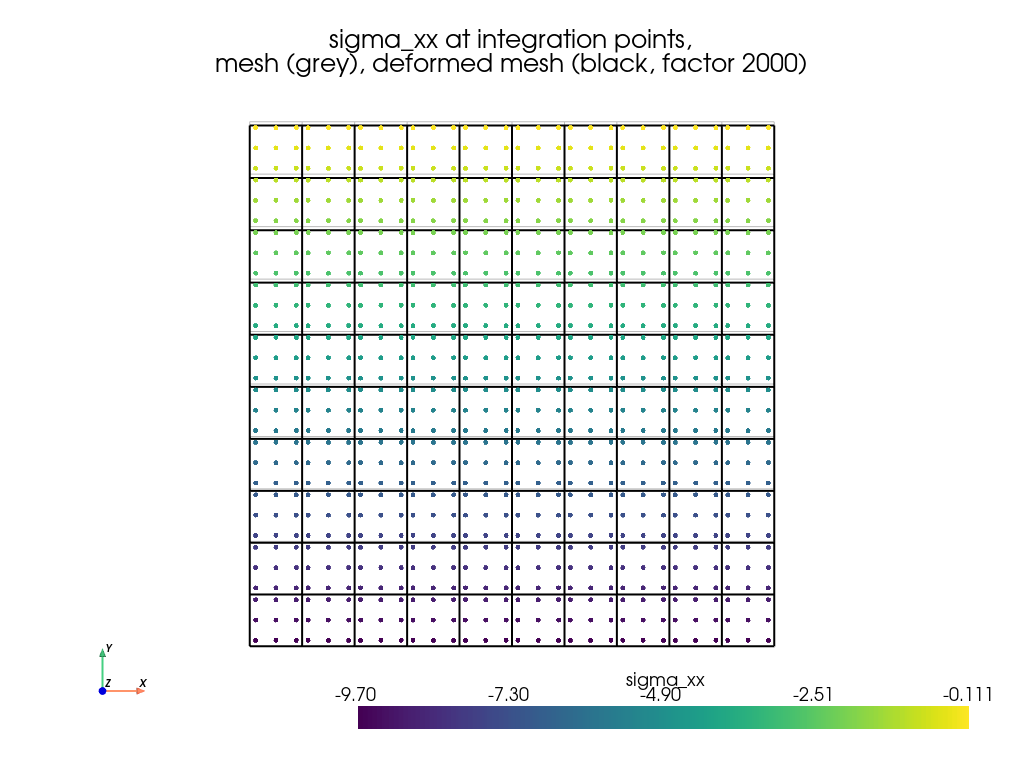

In [10]:
plotter = pv.Plotter()

plotter.add_mesh(
    mesh_pc,
    scalars=mesh_pc.cell_data["sigma_ip"][:, 1],
    label="sigma_xx at integration points",
    point_size=5,
    render_points_as_spheres=True,
    scalar_bar_args={"title": "sigma_xx"},
    lighting=False,
)

mesh_linear = mesh.linear_copy()  # avoids tesselation artefacts in PyVista's rendering
plotter.add_mesh(
    mesh_linear,
    style="wireframe",
    color="#bbbbbb",
    line_width=1,
    lighting=False,
    label="mesh",
)
plotter.add_mesh(
    mesh_linear.warp_by_vector(vectors="displacement", factor=2000),
    style="wireframe",
    color="k",
    line_width=2,
    lighting=False,
    label="warped mesh (factor 2000)",
)

plotter.add_axes()
# plotter.add_legend()
plotter.view_xy()
plotter.add_title(
    "sigma_xx at integration points,\nmesh (grey), deformed mesh (black, factor 2000)",
    font_size=10,
)
plotter.show()

# Comparison to analytical solution


## Nodal displacement

In [11]:
sampled = mesh.sample_over_line((X / 2, 0, 0), (X / 2, Y, 0))

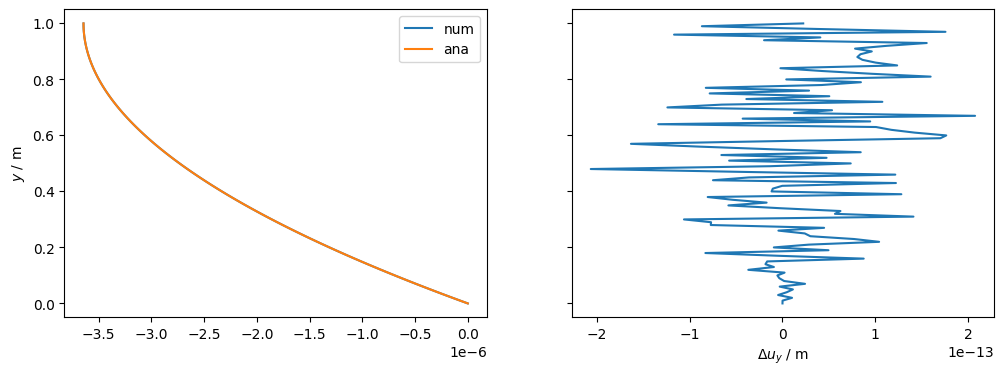

In [12]:
ys = sampled.points[:, 1]
u_ys_num = sampled.point_data["displacement"][:, 1]
u_ys_ana = u_y_ana(ys)

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True)

ax.plot(u_ys_num, ys, label="num")
ax.plot(u_ys_ana, ys, label="ana")

ax2.plot(u_ys_num - u_ys_ana, ys)
assert np.allclose(u_ys_num, u_ys_ana, atol=2.1e-13, rtol=0)

ax.set_ylabel("$y$ / m")
ax2.set_xlabel(r"$\Delta u_y$ / m")

ax.legend()

ax
fig.set_size_inches(12, 4)

In [13]:
# assert correctness of entire displacment field
ys = mesh.points[:, 1]

# u_y must match the analytical solutions
assert np.allclose(
    mesh.point_data["displacement"][:, 1], u_y_ana(ys), atol=1e-15, rtol=0
)

# u_x must be zero
assert np.allclose(mesh.point_data["displacement"][:, 0], 0, atol=1e-15, rtol=0)

# Stress at Integration Points

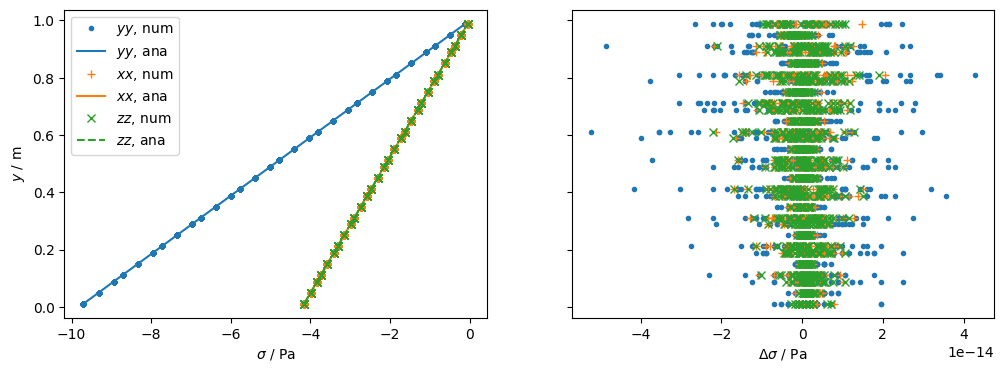

In [14]:
ys = mesh_pc.points[:, 1]
sigma_yys_num = mesh_pc.cell_data["sigma_ip"][:, 1]
sigma_yys_ana = sigma_yy_ana(ys)

sigma_xxs_num = mesh_pc.cell_data["sigma_ip"][:, 0]
sigma_xxs_ana = sigma_xx_ana(ys)

sigma_zzs_num = mesh_pc.cell_data["sigma_ip"][:, 2]
sigma_zzs_ana = sigma_zz_ana(ys)

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True)

(h,) = ax.plot(sigma_yys_num, ys, label="$yy$, num", ls="", marker=".")
ax.plot(sigma_yys_ana, ys, label="$yy$, ana", color=h.get_color())
ax2.plot(sigma_yys_num - sigma_yys_ana, ys, ls="", marker=".")

(h,) = ax.plot(sigma_xxs_num, ys, label="$xx$, num", ls="", marker="+")
ax.plot(sigma_xxs_ana, ys, label="$xx$, ana", color=h.get_color())
ax2.plot(sigma_xxs_num - sigma_xxs_ana, ys, ls="", marker="+")

(h,) = ax.plot(sigma_zzs_num, ys, label="$zz$, num", ls="", marker="x")
ax.plot(sigma_zzs_ana, ys, label="$zz$, ana", ls="--", color=h.get_color())
ax2.plot(sigma_zzs_num - sigma_zzs_ana, ys, ls="", marker="x")

ax.set_xlabel(r"$\sigma$ / Pa")
ax2.set_xlabel(r"$\Delta\sigma$ / Pa")
ax.set_ylabel("$y$ / m")

ax.legend()

ax
fig.set_size_inches(12, 4)

# Checks (Assertions)

In [15]:
from IPython.display import display, HTML


def allclose(x, y, abstol):
    d = np.max(np.abs(x - y))

    if d <= abstol:
        return True

    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    display(
        HTML(
            f"""
    <div class="alert alert-block alert-danger">
        <h3>Error in <span style="font-family: monospace;">allclose()</span></h3>
        difference of {d} exceeds abstol of {abstol}<br>
        field 1 ranges from {xmin} to {xmax} (delta = {xmax - xmin})<br>
        field 2 ranges from {ymin} to {ymax} (delta = {ymax - ymin})<br>
    </div>
    """
        )
    )

    return False

In [16]:
# assert correctness of entire displacment field
ys = mesh_pc.points[:, 1]

# normal stress must match the analytical solutions
# the tolerances are rather high due to the jumps in sigma over element edges
assert allclose(mesh_pc.cell_data["sigma_ip"][:, 1], sigma_yy_ana(ys), 6e-14)
assert allclose(mesh_pc.cell_data["sigma_ip"][:, 0], sigma_xx_ana(ys), 3e-14)
assert allclose(mesh_pc.cell_data["sigma_ip"][:, 0], sigma_zz_ana(ys), 3e-14)

# shear stress must be zero
assert allclose(mesh_pc.cell_data["sigma_ip"][:, 3], 0, 2.3e-14)